# Analysis and price Prediction of Buenos Aires City apartments

### Introduction

This notebook aims to analyze the apartment market in Buenos Aires, Argentina, and develop a predictive model for apartment prices based on various features such as size and location. The dataset contains listings of apartments for sale, including details like price, number of rooms, number of bathrooms, and sometimes whether a garage is included.

The primary objectives are:
- Perform an exploratory data analysis (EDA) to understand the distribution and relationships between different variables.
- Preprocess the data to make it suitable for modeling.
- Develop and evaluate predictive models for apartment prices.
- Draw conclusions based on the analysis and model performance.

## EDA

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv('departamentos-en-venta-2016.csv', sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7564 entries, 0 to 7563
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CALLE                    6182 non-null   object 
 1   NUMERO                   6182 non-null   float64
 2   ID_ZONAPRO               7564 non-null   int64  
 3   OPERACION                7564 non-null   object 
 4   TIPO                     7564 non-null   object 
 5   M2                       7564 non-null   int64  
 6   M2CUB                    7564 non-null   int64  
 7   PRECIOTEXT               7562 non-null   object 
 8   PRECIOARS                7564 non-null   int64  
 9   PRECIOARSM               7564 non-null   int64  
 10  DOLARES                  7564 non-null   int64  
 11  U_S_M2                   7564 non-null   int64  
 12  AMBIENTES                7564 non-null   int64  
 13  ANTIGUEDAD               7564 non-null   int64  
 14  BAÑOS                   

In [64]:
df['COCHERA'] = df['DIRECCION'].apply(lambda x:
                                     1 if re.search(r'\bcochera\w*\b', str(x), re.IGNORECASE)
                                     else 0)
df = df[['DOLARES', 'M2', 'BARRIO', 'CALLE', 'NUMERO', 'AMBIENTES', 'BAÑOS', 'ANTIGUEDAD', 'COCHERA']]
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6182 entries, 0 to 7563
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DOLARES     6182 non-null   int64  
 1   M2          6182 non-null   int64  
 2   BARRIO      6182 non-null   object 
 3   CALLE       6182 non-null   object 
 4   NUMERO      6182 non-null   float64
 5   AMBIENTES   6182 non-null   int64  
 6   BAÑOS       6182 non-null   int64  
 7   ANTIGUEDAD  6182 non-null   int64  
 8   COCHERA     6182 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 483.0+ KB


In [65]:
df['NUMERO'] = df['NUMERO'].astype('int64')
df.sample(5)

,DOLARES,M2,BARRIO,CALLE,NUMERO,AMBIENTES,BAÑOS,ANTIGUEDAD,COCHERA
1899,110000,45,BELGRANO,MOLDES,2900,0,1,4,0
6440,111100,62,ALMAGRO,QUITO,3666,2,2,2016,0
5318,132900,67,SAN CRISTOBAL,SAN JUAN AV.,3060,3,0,2016,0
3518,97020,54,CONSTITUCION,"SAENZ PEÑA, LUIS, PRES.",1700,2,1,0,0
6306,189000,75,RECOLETA,BILLINGHURST,0,3,2,35,0


While plotting scatter plots of `ANTIGUEDAD` (apartment age in years), I found a data point with a value of 2016.


In [66]:
sorted(df['ANTIGUEDAD'].unique())[-5:]

[np.int64(95), np.int64(96), np.int64(100), np.int64(110), np.int64(2016)]

In [67]:
# Fix wrong data
from sklearn.impute import KNNImputer
import numpy as np

df.loc[df['ANTIGUEDAD'] == 2016, 'ANTIGUEDAD'] = np.nan
# Define features that may help in predicting ANTIGUEDAD
features_for_knn = df[['M2', 'AMBIENTES', 'BAÑOS', 'DOLARES']]

imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(features_for_knn)

# Replace the original ANTIGUEDAD column with the imputed values
df['ANTIGUEDAD'] = df_imputed[:, 0]

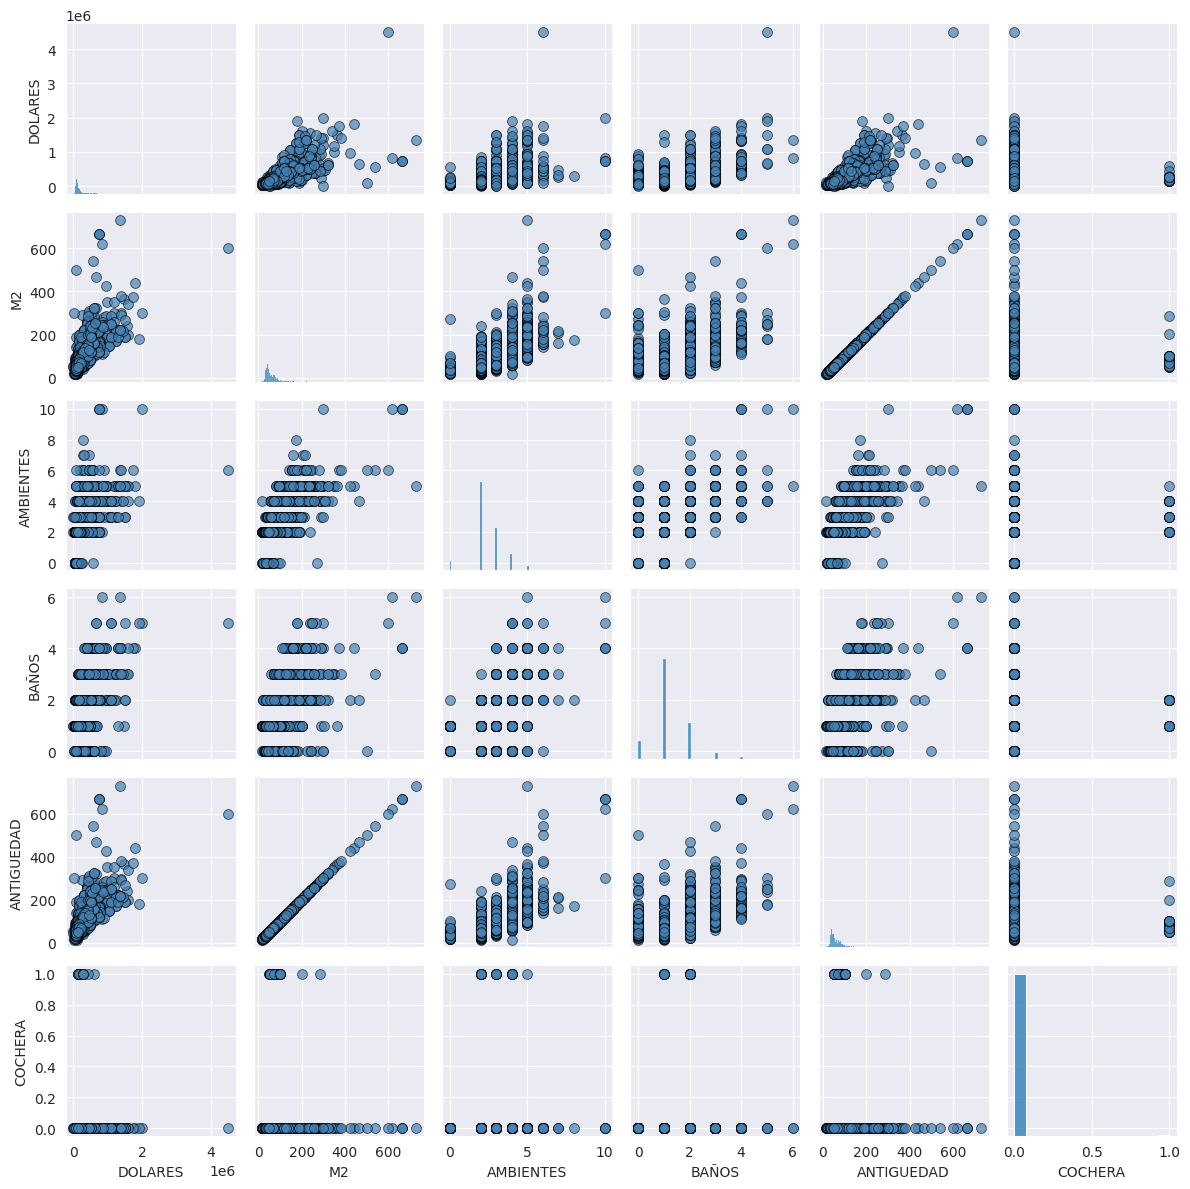

In [68]:
import seaborn as sns

# Scatterplots of each pair of variables to understant their relationship
df_scatter = df.drop(['BARRIO', 'CALLE', 'NUMERO'], axis=1)
sns.pairplot(df_scatter, markers='o',
             plot_kws={'s': 50, 'edgecolor': 'black', 'alpha': 0.7, 'color':'steelblue'},
             height=2, aspect=1)

plt.tight_layout()
plt.show()

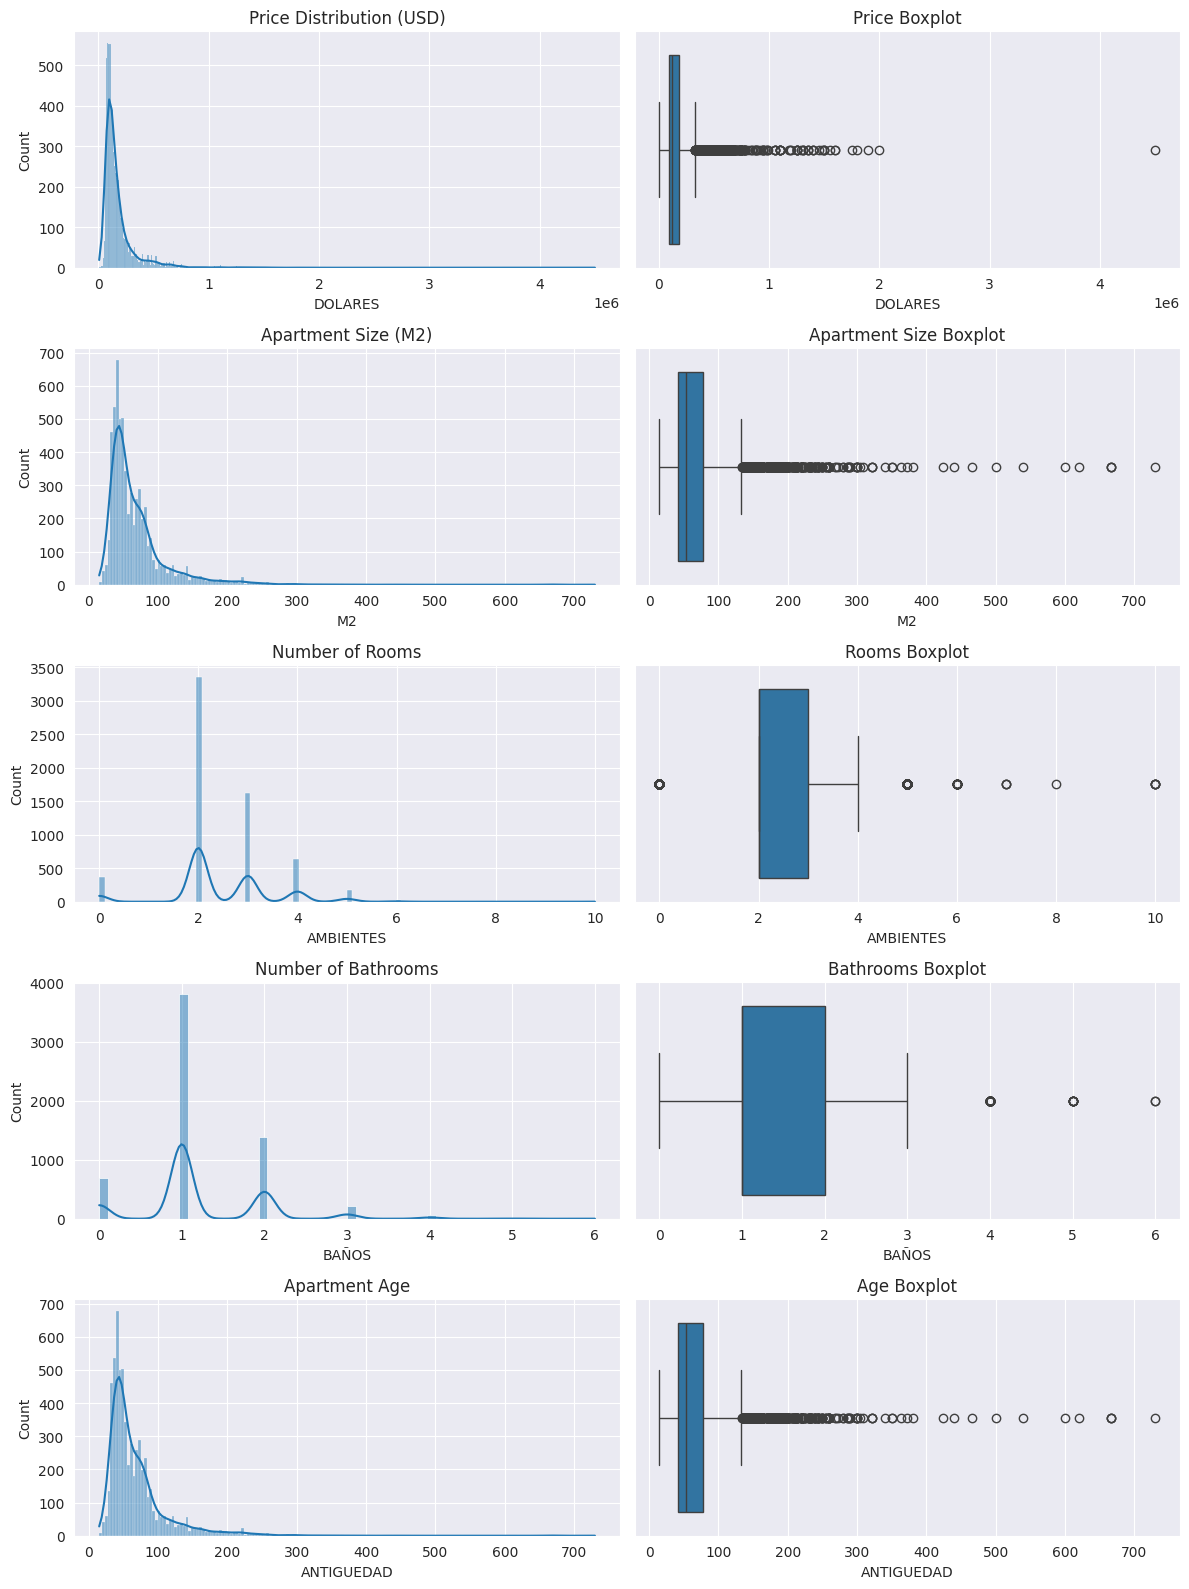

In [69]:
# Plotting distributions of numerical features with boxplots
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

# Price Distribution
sns.histplot(df['DOLARES'], kde=True, ax=axs[0, 0]).set_title('Price Distribution (USD)')
sns.boxplot(x=df['DOLARES'], ax=axs[0, 1]).set_title('Price Boxplot')

# Apartment Size Distribution
sns.histplot(df['M2'], kde=True, ax=axs[1, 0]).set_title('Apartment Size (M2)')
sns.boxplot(x=df['M2'], ax=axs[1, 1]).set_title('Apartment Size Boxplot')

# Number of Rooms Distribution
sns.histplot(df['AMBIENTES'], kde=True, ax=axs[2, 0]).set_title('Number of Rooms')
sns.boxplot(x=df['AMBIENTES'], ax=axs[2, 1]).set_title('Rooms Boxplot')

# Number of Bathrooms Distribution
sns.histplot(df['BAÑOS'], kde=True, ax=axs[3, 0]).set_title('Number of Bathrooms')
sns.boxplot(x=df['BAÑOS'], ax=axs[3, 1]).set_title('Bathrooms Boxplot')

# Apartment Age Distribution
sns.histplot(df['ANTIGUEDAD'], kde=True, ax=axs[4, 0]).set_title('Apartment Age')
sns.boxplot(x=df['ANTIGUEDAD'], ax=axs[4, 1]).set_title('Age Boxplot')

plt.tight_layout()
plt.show()

## Simple Linear Regression

In [70]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [71]:
y = df['DOLARES']
X = df.drop('DOLARES', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((4327, 8), (1855, 8))

In [72]:
preprocessor = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['BARRIO', 'CALLE', 'COCHERA', 'AMBIENTES', 'BAÑOS'])],
    # AMBIENTES and BAÑOS as nominally encoded give better model results than ordinally encoded
    remainder='passthrough',
    force_int_remainder_cols=False
)

model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [73]:
def print_scores(model):
    """
    Prints scores of the current model. Only run with the model parameter right after training it.
    """
    y_train_pred_ = model.predict(X_train)
    y_test_pred_ = model.predict(X_test)
    
    print(f'Training dataset:\n'
      f'R²: {r2_score(y_train, y_train_pred_):.2f}\n'
      f'RMSE: {root_mean_squared_error(y_train, y_train_pred_):.2f}\n'
      f'MAE: {mean_absolute_error(y_train, y_train_pred_):.2f}\n')

    print(f'Test dataset:\n'
          f'R²: {r2_score(y_test, y_test_pred_):.2f}\n'
          f'RMSE: {root_mean_squared_error(y_test, y_test_pred_):.2f}\n'
          f'MAE: {mean_absolute_error(y_test, y_test_pred_):.2f}\n')

In [74]:
model_lr.fit(X_train, y_train)

print_scores(model_lr)

Training dataset:
R²: 0.88
RMSE: 54805.28
MAE: 27742.54

Test dataset:
R²: 0.77
RMSE: 90670.24
MAE: 35655.95



There is clearly overfitting.

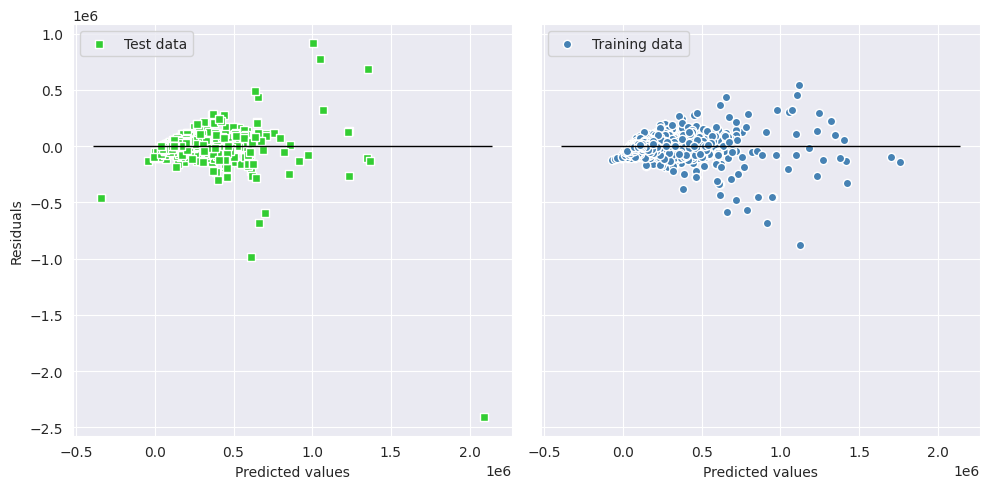

In [75]:
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

x_min = min(y_test_pred.min(), y_train_pred.min())
x_max = max(y_test_pred.max(), y_train_pred.max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot residuals for test and training data
ax1.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')

ax1.set_ylabel('Residuals')
ax1.set_xlabel('Predicted values')
ax2.set_xlabel('Predicted values')

# horizontal line at y=0 (no residuals)
for ax in (ax1, ax2):
    ax.hlines(y=0, xmin=x_min-50000, xmax=x_max+50000, color='black', lw=1)
    ax.legend(loc='upper left')

plt.tight_layout()

## Regularization methods

In [76]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1],
    'model__l1_ratio': [0.3, 0.5, 0.7]
}

model_elastic = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', ElasticNet(random_state=13, max_iter=10000)) # high max iters for very low alpha values
])

grid_search_elastic = GridSearchCV(model_elastic, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

grid_search_elastic.fit(X_train, y_train)

In [78]:
grid_search_elastic.best_params_

{'model__alpha': 0.001, 'model__l1_ratio': 0.5}

In [79]:
best_model_elastic = grid_search_elastic.best_estimator_

print_scores(best_model_elastic)

Training dataset:
R²: 0.86
RMSE: 59307.41
MAE: 29196.00

Test dataset:
R²: 0.77
RMSE: 91261.77
MAE: 34827.40



## Random Forest

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
param_grid = {
    'model__min_samples_split': [2, 4, 8, 12],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_depth': [None, 20]
}

model_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', RandomForestRegressor(random_state=13,
                                    n_estimators=700,
                                    n_jobs=-1,))
])

grid_search_rf = GridSearchCV(model_rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=4, n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['BARRIO',
                                                                          'CALLE',
                                                                          'COCHERA',
                                                                          'AMBIENTES',
                                                                          'BAÑOS'])])),
                                       ('model',
                                        RandomForestRegressor(n_estimators=700,
                                                              n_jobs=-1,
                                                              random_state=13))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 20],
                         'model__min_samples_leaf': [1, 2, 4, 8],
                         'model__min_samples_split': [2, 4, 8, 12]},
             scoring='neg_mean_squared_error', verbose=4)

In [82]:
best_model_rf = grid_search_rf.best_estimator_

print_scores(best_model_rf)

Training dataset:
R²: 0.98
RMSE: 22564.67
MAE: 8795.24

Test dataset:
R²: 0.72
RMSE: 99780.08
MAE: 22922.41



In [84]:
grid_search_rf.best_params_

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}


## Conclusion

In this analysis, we explored various methods to predict apartment prices in Buenos Aires. Among the models tested, Elastic Net regularization demonstrated the best performance after getting their hyperparameters through a GridSearch cross validation, outperforming both standard Linear Regression and Random Forest. This indicates that a combination of linear regression with both L1 and L2 penalties effectively captures the underlying relationships in the data, providing a more robust and accurate predictive model.